In [1]:
from google.colab import files
files.upload()

Saving SGDW.py to SGDW.py
Saving RAdam.py to RAdam.py
Saving OneCycle.py to OneCycle.py
Saving Lookahead.py to Lookahead.py
Saving CLR.py to CLR.py
Saving AdamW.py to AdamW.py


{'AdamW.py': b'import math\nimport torch\nfrom torch.optim.optimizer import Optimizer\n\nclass AdamW(Optimizer):\n    r"""Implements Adam algorithm with decoupled weight decay.\n\n    It has been proposed in `DECOUPLED WEIGHT DECAY REGULARIZATION`_.\n    Below is modification of adam code from pytorch repository(https://github.com/pytorch/pytorch)\n\n    Arguments:\n        params (iterable): iterable of parameters to optimize or dicts defining\n            parameter groups\n        lr (float, optional): learning rate (default: 1e-3)\n        betas (Tuple[float, float], optional): coefficients used for computing\n            running averages of gradient and its square (default: (0.9, 0.999))\n        eps (float, optional): term added to the denominator to improve\n            numerical stability (default: 1e-8)\n        weight_decay (float, optional): weight decay (default: 0)\n        amsgrad (boolean, optional): whether to use the AMSGrad variant of this\n            algorithm from t

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [0]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import math
import tqdm as tqdm
from Lookahead import Lookahead
from AdamW import AdamW
from RAdam import RAdam

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
np.random.seed(42)

# Load Dataset

In [0]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

In [0]:
normalize = transforms.Normalize(mean=mean, std=std)
train_transforms = transforms.Compose([
                    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize
                ])
valid_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    normalize
                ])

In [8]:
trainset = CIFAR10('./data', train=True, download=True, transform=train_transforms)
testset = CIFAR10('./data', train=False, download=True, transform=valid_transforms)

0it [00:00, ?it/s]

170500096it [00:06, 27278046.59it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
bs=128
epochs=90
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=4)

# Plot Images

In [0]:
# Plot few of the images
# This can be used to print predictions too
def plot_img(preds=None, is_pred=False):        
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred:
            img_xy = np.random.randint(len(testset));
            img = testset[img_xy][0].numpy()
            #img = img * std + mean
        else:
            img_xy = np.random.randint(len(trainset));
            img = trainset[img_xy][0].numpy()
            #img = img * std + mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img , (1,2,0)))
    plt.show()

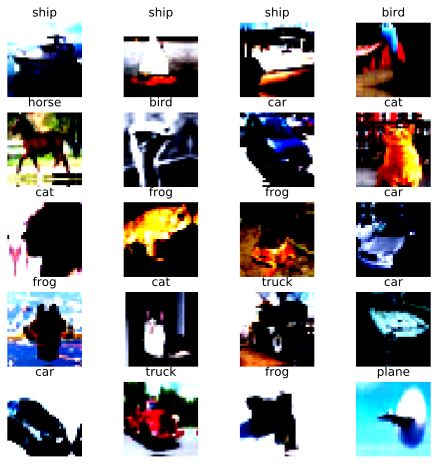

In [12]:
plot_img()

# save and load checkpoint

In [0]:
def save_checkpoint(model, is_best, filename='data/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [0]:
def load_checkpoint(model, filename = 'data/checkpoint.pth.tar'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()):
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

# Global variables

In [0]:
train_loss = 0.0
test_loss = 0.0
best_acc = 0.0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

In [0]:
total = 0
correct = 0

# Helper functions

In [0]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = target.size(0)
    total += batch_size    
    _, pred = output.max(dim=1)
    if is_test:
        preds.extend(pred)
    correct += torch.sum(pred == target.data)
    return (correct.float() / total) * 100

In [0]:
def reset():
    global total, correct
    global train_loss, test_loss, best_acc
    global trn_accs, trn_losses, val_accs, val_losses
    total, correct = 0, 0
    train_loss, test_loss, best_acc = 0.0, 0.0, 0.0
    trn_losses, trn_accs, val_accs, val_losses = [], [], [], []

In [0]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

# Train and Test

In [0]:
def train(epoch=0, model=None, optimizer=None):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98

    for i, (input, target) in enumerate(train_loader):
        bt_start = time.time()
        input, target = input.to(device), target.to(device)
        var_ip, var_tg = Variable(input), Variable(target)
                                    
        output = model(var_ip)
        loss = criterion(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
def test(model=None):
    with torch.no_grad():
        model.eval()
        global val_accs, val_losses
        running_loss = 0.
        avg_beta = 0.98
        for i, (input, target) in enumerate(test_loader):
            bt_start = time.time()
            input, target = input.to(device), target.to(device)
            var_ip, var_tg = Variable(input), Variable(target)
            output = model(var_ip)
            loss = criterion(output, var_tg)
        
            running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss.item(), prec, time.time()-bt_start)
        
            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [0]:
def fit(model=None, optimizer=None, sched=None):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    for j in range(epochs):
        train(j, model, optimizer)
        test(model)
        if sched:
          sched.step(j)
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_losses[-1], val_losses[-1], trn_accs[-1], val_accs[-1]))

# Model

In [23]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 37.5MB/s]


In [0]:
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10, bias=True)

In [25]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in model.parameters():
  param.requires_grad = True

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4, momentum=0.9)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)

In [0]:
save_checkpoint(model, True, filename='before_sgd_resnet18.pth.tar')

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
reset()

In [0]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.81690471	0.70371581	65.76999664	67.40999603
2	0.64692206	0.60518452	71.73363495	72.41083527
3	0.57989867	0.54954065	74.48117828	74.88611603
4	0.51921393	0.52132156	76.31913757	76.57333374
5	0.47950729	0.52758675	77.64620972	77.79267120
6	0.47421528	0.52534188	78.64743042	78.74694824
7	0.43572727	0.50823654	79.49121857	79.58833313
8	0.41682540	0.47581992	80.19744873	80.27375031
9	0.40430805	0.49821593	80.83415222	80.88944244
10	0.38623603	0.47633889	81.39305115	81.44149780
11	0.37161840	0.47630971	81.88215637	81.92318726
12	0.36791777	0.47682066	82.31619263	82.33805847
13	0.35056007	0.46529305	82.72531891	82.75153351
14	0.33078309	0.44768207	83.09409332	83.12249756
15	0.31880053	0.45511365	83.45381927	83.47522736
16	0.32347278	0.44313050	83.77073669	83.78531647
17	0.29370204	0.46006617	84.08227539	84.09422302
18	0.29418164	0.46254597	84.36411285	84.37139130
19	0.28816694	0.48537516	84.63220978	84.63859558
20	0.27253683	0.53425918	84.88790131	

In [0]:
save_checkpoint(model, True, 'sgd_resnet18_9331.pth.tar')

In [0]:
ep_sgd_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_sgd_losses.append(train_stats.losses[i])
        
ep_sgd_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_sgd_lossesv.append(test_stats.losses[i])

In [0]:
ep_sgd_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_sgd_accs.append(train_stats.precs[i])
        
ep_sgd_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_sgd_accsv.append(test_stats.precs[i])

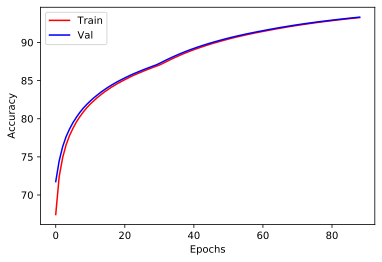

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_sgd_accs, 'r', label='Train')
plt.plot(ep_sgd_accsv, 'b', label='Val')
plt.legend()
plt.savefig('sgd_resnet18_9331_acc.jpg')

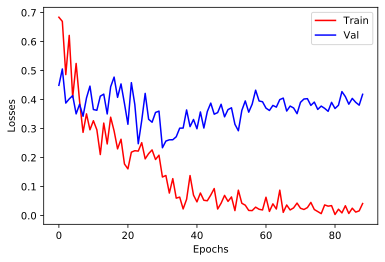

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_sgd_losses, 'r', label='Train')
plt.plot(ep_sgd_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('sgd_resnet18_9331_loss.jpg')

In [0]:
from google.colab import files
files.download('./sgd_resnet18_9331.pth.tar')
files.download('./sgd_resnet18_9331_acc.jpg')
files.download('./sgd_resnet18_9331_loss.jpg')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 49472, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# ADAMW

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
reset()

In [0]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

In [0]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.85931547	0.74565890	61.99799728	64.05332947
2	0.67852404	0.62613348	69.09091187	69.87916565
3	0.57934476	0.56550580	72.49823761	72.95889282
4	0.54214736	0.55001908	74.68304443	74.97708130
5	0.48800774	0.51750468	76.35551453	76.57033539
6	0.45020250	0.50406531	77.65742493	77.81666565
7	0.42087057	0.49898211	78.70146942	78.81309509
8	0.39916292	0.49342473	79.60149384	79.69166565
9	0.36777102	0.47970856	80.37698364	80.45500183
10	0.36944244	0.48241919	81.07847595	81.12416840
11	0.32664748	0.46933987	81.69215393	81.73636627
12	0.31669978	0.46578803	82.25309753	82.28903198
13	0.29019814	0.47259745	82.77818298	82.80781555
14	0.28558570	0.47556769	83.25878906	83.27761841
15	0.27061262	0.48767383	83.70259094	83.71256256
16	0.25694627	0.48473809	84.11262512	84.12427521
17	0.23527824	0.49744417	84.49365997	84.50196075
18	0.23278298	0.49140304	84.84700775	84.85120392
19	0.22274712	0.48830497	85.18628693	85.18920898
20	0.21774973	0.50135920	85.51193237	

In [0]:
save_checkpoint(model, True, 'adamw_resnet18_9278.pth.tar')

In [0]:
ep_adamw_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_adamw_losses.append(train_stats.losses[i])
        
ep_adamw_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_adamw_lossesv.append(test_stats.losses[i])

In [0]:
ep_adamw_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_adamw_accs.append(train_stats.precs[i])
        
ep_adamw_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_adamw_accsv.append(test_stats.precs[i])

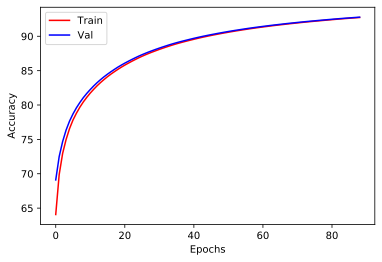

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_adamw_accs, 'r', label='Train')
plt.plot(ep_adamw_accsv, 'b', label='Val')
plt.legend()
plt.savefig('adamw_resnet18_9278_acc.jpg')

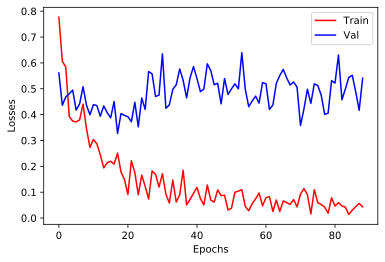

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_adamw_losses, 'r', label='Train')
plt.plot(ep_adamw_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('adamw_resnet18_9278_loss.jpg')

In [0]:
from google.colab import files
files.download('./adamw_resnet18_9278.pth.tar')
files.download('./adamw_resnet18_9278_acc.jpg')
files.download('./adamw_resnet18_9278_loss.jpg')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 46332, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# Lookahead with SGD

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optims = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [0]:
sched_la = torch.optim.lr_scheduler.StepLR(optims, step_size=30, gamma=0.2)

In [0]:
la_optim = Lookahead(optims, alpha=0.5, k=10)

In [0]:
fit(model, la_optim, sched_la)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.78376562	0.67640162	65.41400146	67.35832977
2	0.63638799	0.56469261	71.63272858	72.40666962
3	0.56728234	0.55022529	74.54941559	74.90222168
4	0.52422578	0.51236753	76.31652069	76.56083679
5	0.48728402	0.50122342	77.66379547	77.83066559
6	0.46345733	0.49776740	78.69713593	78.81610870
7	0.44508148	0.53268120	79.60024261	79.65690613
8	0.39734845	0.55754017	80.32170868	80.34729004
9	0.38279466	0.53214014	80.94773865	80.97981262
10	0.37531324	0.44296175	81.50372314	81.56616974
11	0.35894964	0.45049450	82.03430939	82.08181763
12	0.32494530	0.45984588	82.51816559	82.55791473
13	0.32157368	0.44317434	82.94908905	82.98513031
14	0.31340349	0.46740773	83.33915710	83.35725403
15	0.31834575	0.48375036	83.70584869	83.71533966
16	0.28913719	0.49326659	84.05231476	84.06250000
17	0.26896076	0.47256352	84.37772369	84.38343048
18	0.27121469	0.48869965	84.68000031	84.68852234
19	0.26140925	0.54489059	84.96813965	84.95587921
20	0.25490629	0.45584670	85.22000122	

In [0]:
save_checkpoint(model, True, 'lookahead_sgd_resnet18_9334.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

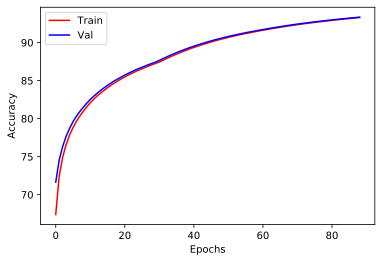

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('lookahead_sgd_resnet18_9334_acc.jpg')

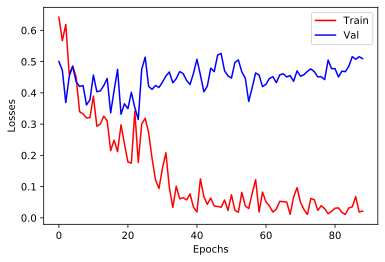

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('lookahead_sgd_resnet18_9334_loss.jpg')

In [0]:
from google.colab import files
files.download('./lookahead_sgd_resnet18_9334.pth.tar')
files.download('./lookahead_sgd_resnet18_9334_acc.jpg')
files.download('./lookahead_sgd_resnet18_9334_loss.jpg')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 47506, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# RAdam

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optimizer = RAdam( model.parameters(), lr=1e-4, weight_decay=1e-1)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)

In [36]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.17956812	1.03350742	41.84599686	45.50333405
2	0.85558891	0.78601485	55.61635971	57.07500076
3	0.71838177	0.66642632	62.00117493	62.84388733
4	0.63973970	0.60533132	65.97217560	66.52625275
5	0.56805268	0.56476555	68.85276031	69.24832916
6	0.54195648	0.53587582	71.02085114	71.31999969
7	0.48986751	0.52390686	72.73244476	72.96714020
8	0.46415678	0.50217543	74.17255402	74.34333801
9	0.42862184	0.49727216	75.36245728	75.50629425
10	0.40800423	0.47950202	76.39796448	76.52099609
11	0.38016815	0.49098657	77.33753967	77.43302917
12	0.36039637	0.48207030	78.16928864	78.25582886
13	0.34154434	0.49398275	78.91271973	78.97999573
14	0.30856392	0.48183833	79.59565735	79.65631104
15	0.31408957	0.48541321	80.21157074	80.25866699
16	0.27965618	0.49433110	80.78620911	80.83020782
17	0.26899641	0.48141070	81.32435608	81.36186218
18	0.26476553	0.46516748	81.81813049	81.85221863
19	0.25845433	0.48241043	82.28663635	82.31289673
20	0.23241759	0.47445726	82.72588348	

In [0]:
save_checkpoint(model, True, 'radam_resnet18_9301.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

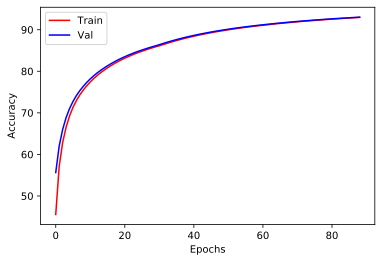

In [40]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('radam_resnet18_9301_acc.jpg')

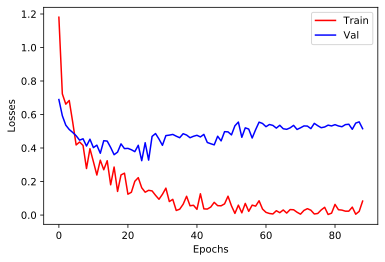

In [41]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('radam_resnet18_9301_loss.jpg')

In [0]:
from google.colab import files
files.download('./radam_resnet18_9301.pth.tar')
files.download('./radam_resnet18_9301_acc.jpg')
files.download('./radam_resnet18_9301_loss.jpg')

# Lookahead with radam

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optim = RAdam( model.parameters(), lr=1e-3, weight_decay=1e-4)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=30, gamma=0.2)

In [0]:
optimizer = Lookahead(optim, alpha=0.5, k=10)

In [63]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.84039709	0.73238619	58.65799713	61.38499832
2	0.66926891	0.61152111	67.62818146	68.59583282
3	0.62486414	0.57794141	71.53353119	72.03222656
4	0.55522068	0.57696064	73.90174103	74.17916870
5	0.52561849	0.59002180	75.52620697	75.68133545
6	0.49826776	0.56802273	76.68943024	76.81278229
7	0.46899372	0.53620532	77.66439056	77.76332855
8	0.45046685	0.54581055	78.47000122	78.53542328
9	0.44863516	0.59643967	79.17263794	79.18926239
10	0.41838204	0.43705980	79.74796295	79.83950043
11	0.39751629	0.43282110	80.35430908	80.43394470
12	0.39888706	0.44356672	80.88168335	80.94152832
13	0.37322336	0.44731551	81.35636139	81.40499878
14	0.35722745	0.48546841	81.79071808	81.82142639
15	0.34940608	0.45884905	82.19045258	82.22200012
16	0.35149808	0.52451462	82.55905151	82.56771088
17	0.32982025	0.48660794	82.88891602	82.90304565
18	0.31618896	0.49432394	83.20410919	83.21592712
19	0.30027402	0.50022415	83.50017548	83.50605011
20	0.29747252	0.44017676	83.78185272	

In [0]:
save_checkpoint(model, True, 'radam_lookahead_resnet18_9321.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

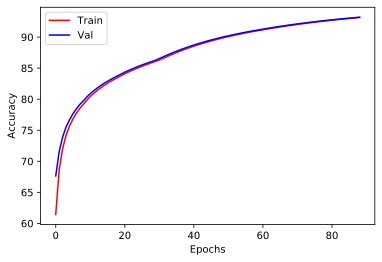

In [68]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('radam_lookahead_resnet18_9321_acc.jpg')

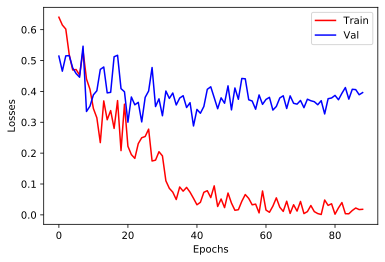

In [69]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('radam_lookahead_resnet18_9321_loss.jpg')

In [0]:
from google.colab import files
files.download('./radam_lookahead_resnet18_9321.pth.tar')
files.download('./radam_lookahead_resnet18_9321_acc.jpg')
files.download('./radam_lookahead_resnet18_9321_loss.jpg')